
# Exercice 3 : LIME (SVM)

## Objectif
Implémenter LIME pour interpréter un Support Vector Machine (SVM) sur un problème de classification binaire (ou multiclasse) avec deux caractéristiques.

Nous utilisons le fichier `lime.py` qui contient l'implémentation des fonctions `sample_points`, `weight_points` et `fit_explainer_model`.


In [2]:

import sys
sys.path.append(".")
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from Dataset.dataset import Dataset
import lime  # Corrected from 'limen'

# Load Dataset (Wheat Seeds)
dataset = Dataset("wheat_seeds", [1, 5], [7], normalize=True, categorical=True)
(X_train, y_train), (X_test, y_test) = dataset.get_data()

# Train SVM
model = SVC(gamma='auto')
model.fit(X_train, y_train)

# Define Interest Point and Parameters
x_interest = np.array([0.31, 0.37])
points_per_feature = 50
n_points = 1000
labels = dataset.get_input_labels()
colors = {0: "purple", 1: "green", 2: "orange"}



### (a) Inspection des fonctions implémentées

**1. Que représente la surface de prédiction affichée sur le graphique ?**
La surface de prédiction représente les frontières de décision globales du modèle SVM dans l'espace des deux caractéristiques sélectionnées. Les zones colorées indiquent la classe prédite par le modèle pour chaque point de cet espace.

**2. Que signifient les différentes couleurs observées dans l’espace des caractéristiques ?**
Les couleurs représentent les différentes classes cibles (variétés de blé dans ce dataset). Par exemple, violet, vert et orange correspondent aux trois classes possibles prédites par le modèle.

**3. Comment interprétez-vous les frontières de décision visibles sur le graphique ?**
Les frontières de décision séparent les zones de couleurs différentes. Elles indiquent où le modèle change de prédiction. Leur forme (courbée, non-linéaire) suggère que le noyau du SVM (probablement RBF) capture des relations non-linéaires complexes entre les caractéristiques.

**4. Que peut-on dire du comportement global du SVM à partir de cette visualisation ?**
On peut voir la capacité du SVM à séparer les classes. Certaines zones peuvent être complexes ou imbriquées, montrant où le modèle est incertain ou s'il fait du surapprentissage (si les frontières sont très irrégulières). Ici, les frontières semblent raisonnablement lisses.


Running get_grid and plot_grid...


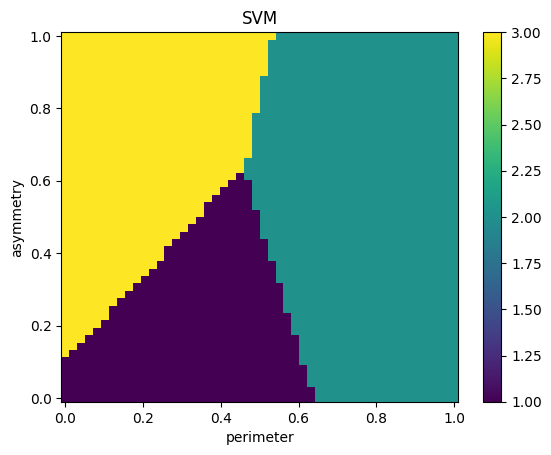

In [3]:

# 1. Get Grid and Plot SVM Decision Boundary
print("Running get_grid and plot_grid...")
u, v, z = lime.get_grid(model, dataset, points_per_feature=points_per_feature)
plt = lime.plot_grid(u, v, z, labels=labels, title="SVM")
plt.show()


### (b) Échantillonnage des points

#### 5. Pourquoi est-il nécessaire d’échantillonner des points autour de l’observation à expliquer ?
LIME cherche à expliquer la décision du modèle **localement**.  
L’échantillonnage autour de l’observation permet d’analyser **le comportement du modèle dans son voisinage immédiat** et d’approximer localement la frontière de décision.

---

#### 6. Comment la taille de la zone échantillonnée influence-t-elle l’explication produite par LIME ?
- **Zone trop petite** : peu de variation, explication instable et bruitée.
- **Zone trop grande** : l’explication devient globale et perd sa fidélité locale.  
Il faut donc un **compromis** pour obtenir une explication fidèle autour du point expliqué.

---

#### 7. Que se passe-t-il si les points sont échantillonnés trop loin du point à expliquer ?
Les points éloignés reflètent la **structure globale du modèle**, différente du comportement local.  
L’explication obtenue ne justifie alors plus correctement la prédiction de l’instance étudiée et devient **peu pertinente localement**.


Running sample_points...


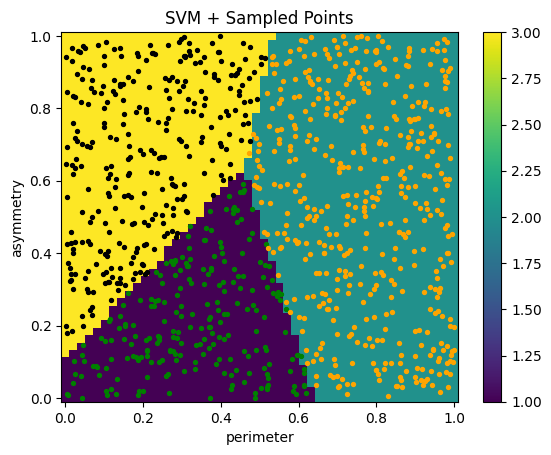

In [4]:

# 2. Sample Points
print("Running sample_points...")
Z_sampled, y_sampled = lime.sample_points(model, dataset, n_points)

# Plot Sampled Points
plt = lime.plot_grid(u, v, z, labels=labels, title="SVM + Sampled Points")
lime.plot_points_in_grid(plt, Z_sampled, y_sampled, colors=colors)
plt.show()


### (c) Pondération des points

#### 8. Comment la distance au point x influence-t-elle le poids attribué à un point échantillonné ?
Le poids d’un point échantillonné **diminue lorsque la distance au point x augmente**.  
La fonction de pondération (noyau exponentiel) attribue un **poids élevé aux points proches** et un **poids très faible aux points éloignés**.

---

#### 9. Pourquoi les points proches de x ont-ils un poids plus élevé ?
Parce que LIME vise une **fidélité locale**.  
Les points proches de x sont les plus représentatifs de la décision prise pour cette instance et doivent donc influencer davantage le modèle explicatif.

---

#### 10. Comment cette pondération est-elle reflétée visuellement sur le graphique ?
Visuellement, la pondération est représentée par la **taille des points** :  
les points proches de l’instance expliquée apparaissent **plus gros**, tandis que les points éloignés sont **plus petits**, reflétant leur poids plus faible.


Running weight_points...


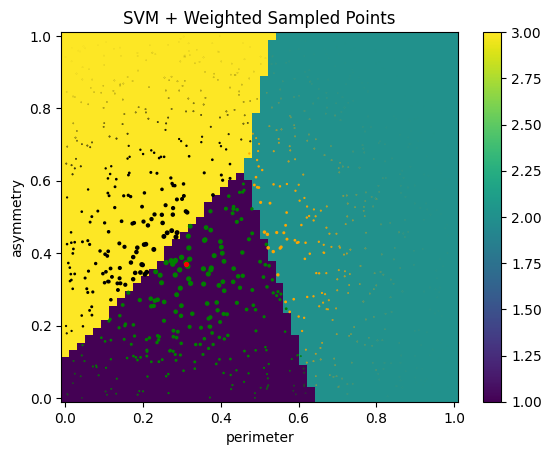

In [5]:

# 3. Weight Points
print("Running weight_points...")
weights = lime.weight_points(x_interest, Z_sampled)

# Plot Weighted Points
plt = lime.plot_grid(u, v, z, labels=labels, title="SVM + Weighted Sampled Points")
lime.plot_points_in_grid(plt, Z_sampled, y_sampled, weights, colors, x_interest)
plt.show()


### (d) Ajustement du modèle explicatif local (Arbre de Décision)

#### 11. Limitations potentielles / problèmes
Un arbre de décision est un modèle **non lisse**, basé sur des découpages en escalier.  
Il peut difficilement approximer une **frontière de décision oblique ou continue** comme celle du SVM, même localement.  
De plus, il est **instable** et sensible aux variations de l’échantillonnage.

---

#### 12. Comment l’arbre de décision approxime-t-il localement la frontière du SVM ?
L’arbre partitionne l’espace local en **rectangles homogènes** à l’aide de règles simples (seuils sur les variables).  
Il cherche à s’aligner au mieux sur la frontière du SVM **dans les zones fortement pondérées (proches de x)** afin de minimiser l’erreur locale pondérée.

---

#### 13. Dans quelles régions du graphique cette approximation est-elle la plus fiable ?
L’approximation est la plus fiable **dans le voisinage immédiat du point x**, là où les points ont un **poids élevé** (points les plus visibles).

---

#### 14. Pourquoi l’approximation locale devient-elle incorrecte loin du point x ?
Loin de x, les points ont un **poids très faible**, donc l’arbre n’est pas pénalisé pour les erreurs dans ces régions.  
Il peut alors produire des décisions arbitraires qui **ne reflètent plus le comportement réel du SVM**.

---

#### 15. Que révèle cela sur la différence entre modèle global et explication locale ?
Le **modèle global (SVM)** capture la complexité de la frontière sur tout l’espace.  
L’**explication locale (arbre)** est une approximation simplifiée, **valable uniquement dans une zone restreinte autour de x**.  
Une explication locale ne doit donc **jamais être extrapolée** pour interpréter le modèle global.


Fitting explainer model...


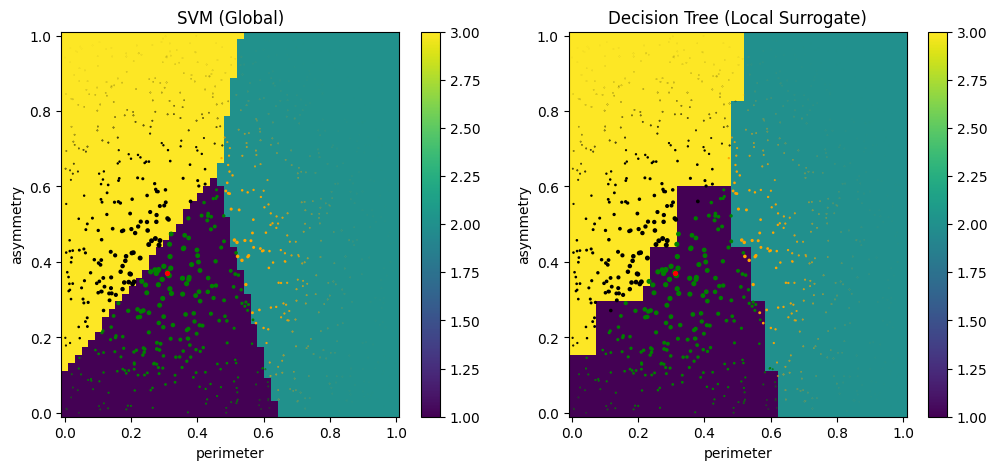

In [6]:

# 4. Fit Explainer Model (Decision Tree)
print("Fitting explainer model...")
explainer = lime.fit_explainer_model(Z_sampled, y_sampled, weights)

# 5. Compare Models
fig = plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
lime.plot_grid(u, v, z, labels=labels, title="SVM (Global)", embedded=True)
lime.plot_points_in_grid(plt, Z_sampled, y_sampled, weights, colors, x_interest)

plt.subplot(1, 2, 2)
u2, v2, z2 = lime.get_grid(explainer, dataset, points_per_feature=points_per_feature)
lime.plot_grid(u2, v2, z2, labels=labels, title="Decision Tree (Local Surrogate)", embedded=True)
lime.plot_points_in_grid(plt, Z_sampled, y_sampled, weights, colors, x_interest)

plt.show()


### Analyse critique basée sur les visualisations

#### 16. En quoi les graphiques générés par LIME facilitent-ils la compréhension du comportement du modèle ?
Les visualisations LIME permettent de **rendre la décision du modèle visible**.  
On observe la position de l’instance par rapport à la frontière de décision, la distribution des points voisins et la **forme locale de la frontière**, ce qui aide à comprendre une décision issue d’un modèle boîte noire.

---

#### 17. Dans quels cas les explications visuelles produites par LIME peuvent-elles être trompeuses ?
Les explications peuvent être trompeuses lorsque :
- seules **quelques dimensions** sont visualisées alors que le modèle en utilise beaucoup (biais de projection) ;
- l’**échantillonnage est insuffisant ou mal réparti**, ce qui peut produire une frontière locale artificielle.

---

#### 18. Quel est l’impact du nombre de points échantillonnés sur la qualité de l’explication ?
- **Peu de points** : explication instable et peu fiable.
- **Beaucoup de points** : meilleure couverture du voisinage local et **approximation plus stable** de la frontière de décision.  
Il existe donc un compromis entre qualité de l’explication et coût de calcul.

---

#### 19. Comment la position du point x par rapport aux frontières de décision influence-t-elle l’interprétation ?
- Si le point x est **proche de la frontière**, la prédiction est sensible à de petites variations et l’incertitude est élevée.
- Si le point x est **loin de la frontière**, la décision est plus robuste et l’explication montre une forte confiance du modèle.

---

#### 20. Citez deux limites de la méthode LIME observables à partir des graphiques
1. **Instabilité** : l’échantillonnage aléatoire peut produire des explications légèrement différentes d’une exécution à l’autre.
2. **Choix du voisinage** : la définition de la zone locale (via `kernel_width`) est subjective et influence fortement l’explication produite.
